# RelativisticDynamics.jl demo

This notebook demonstrates how to use the `RelativisticDynamics.jl` package

In [36]:
using Revise
using RelativisticDynamics

---

## 1. Example Orbital Trajectory

The core aim of `RelativisticDynamics.jl` is to be able to accurately describe the spin-orbital evolution of a relativistic system. This can be easily done using the default settings as:

In [37]:
solution,model = orbit();

We can use `Plots.jl` in conjunction with the inbuilt `RelativisticDynamics.jl` plotting recipe to plot e.g. the orbital trajectory:

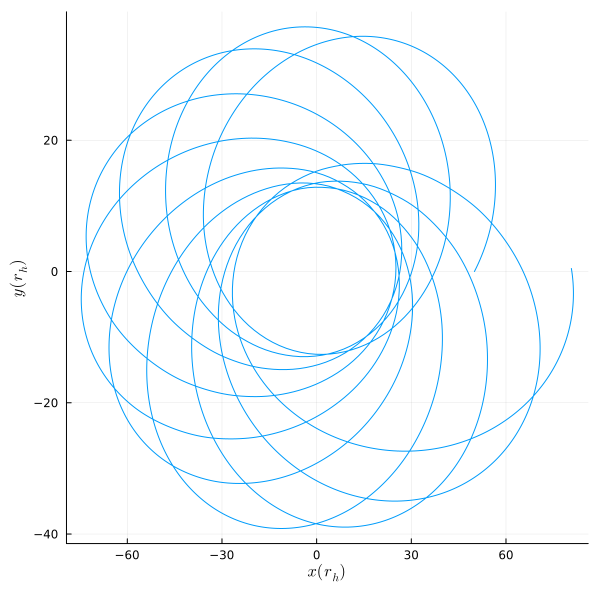

In [38]:
using Plots 
plot(solution,model.constants.a)

---

## 2. Flexible number format

How do the solutions compare using different number formats?

In [39]:
solutionF64,modelF64 = orbit(NF=Float64);
solutionF32,modelF32 = orbit(NF=Float32);

See also Posits, Stochastic rounding, DoubleFloats.jl, ArbNumerics.jl e.g. https://tutorials.sciml.ai/html/type_handling/01-number_types.html



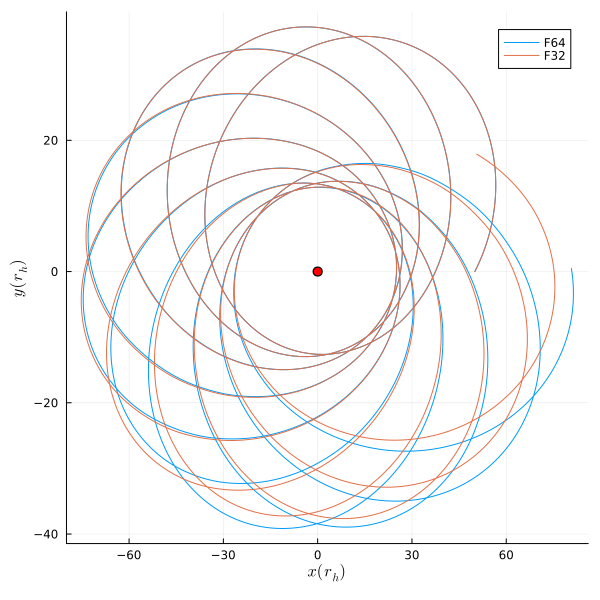

In [40]:
plt = plot(solutionF64,modelF64.constants.a,label="F64")
plt = plot!(solutionF32,modelF32.constants.a,linecolor=2,label="F32",legend=true)
plt = scatter!(0:0, 0:0,markercolor="red",markersize=5,label="")

## 3. Automatic Differentiation 

`RelativisticDynamics.jl` is written so as to be generally differentiable by the [differentiation tools in Julia](https://juliadiff.org/).

A slew of different tool exist. We have been working using [Zygote.jl](https://github.com/FluxML/Zygote.jl) as a well-established, well-tested AD library in Julia.  

Let's see how this works by considering how the numerical solution varies with eccentricity. That is, want to calculate

$$\frac{\partial L}{\partial e} $$

where $L$ is some general loss function which depends on the output of `orbit()`.


To define our loss function, lets first get a reference solution:


In [41]:
# Get a reference solution.
# We will use this to define a gradient 
reference_solution,reference_model = orbit(Norbits=1); #using the default parameters

Given this reference solution, we define some arbitrary loss that compares the difference in the final value of the $r$-coordinate at the end of the integration.

In [42]:
function loss_function(reference,e)

    # Run the model using the new value of e
    solution,model = orbit(e=e,Norbits=1)
    

    r0 = last(reference[2,:])  # The last r value of the reference solution
    r = last(solution[2,:])    # The last r value of the new solution
    loss = abs(r0 - r)         # Loss
  
    return loss

end;

We can explore explicitly how this loss function varies with $e$:

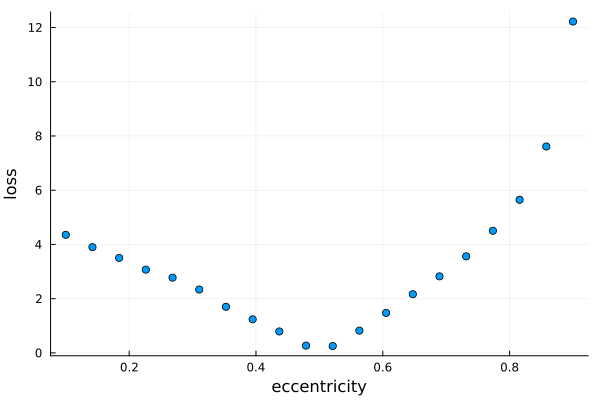

In [43]:
N = 20 #number of samples
loss_data = zeros(Float64,N,2)
for (i,v) in pairs(range(0.1,0.9,N))
    loss = loss_function(reference_solution,v)
    loss_data[i,1] = v 
    loss_data[i,2] = loss
end;

# Plot the eccentricity vs loss 
scatter(loss_data[:,1], loss_data[:,2],
        legend=false,
        xlabel = "eccentricity",
        ylabel = "loss") 


Ok that makes sense - the loss is minimal at $e=0.5$ which is the value used in the reference solution and then diverges at low/high $e$.

Now, suppose we have the reference solution, but we don't know the eccentricity.

We can guess some at some eccentricity and see how the solution compares to the reference i.e. calculate the loss.

But given this loss what do we do next? Guess a higher $e$? Lower $e$? By how much do we increase/decrease $e$? This is a classic optimization problem that - if we had a gradient - could be trivially solved by gradient descent. 

However, using AD and Zygote we can also get the gradient of the solution!

Lets see how this works. All wee need to do is change one line from above:



In [44]:
using Zygote
using SciMLSensitivity

In [45]:
loss_gradient_data = zeros(Float64,N,2)
for (i,v) in pairs(range(0.1,0.9,N))
    loss_g = Zygote.gradient(x -> loss_function(reference_solution,x),v)[1]
    loss_gradient_data[i,1] = v 
    loss_gradient_data[i,2] = loss_g
end

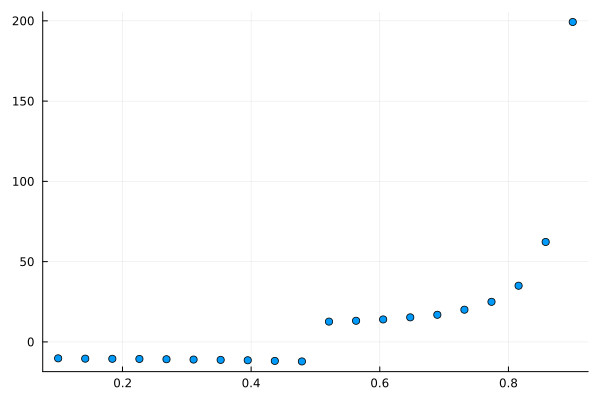

In [46]:
scatter(loss_gradient_data[:,1], loss_gradient_data[:,2],legend=false) # eccentricity vs gradient 

In [47]:

# """
#     PlotTrajectory(solution,model,dimensions=[1,2,3],savepath="")
# Plot trajectory of a body. Assumes coordinates are Boyer Lindquist. 
# Plots in either 2D or 3D depending on specification of dimensions.
# Saves a low resolution PNG figure to disk in example_media/
# """
# function PlotTrajectory(solution,model,dimensions=[1,2,3],savepath="")

#     @unpack a = model.parameters    #Get the BH spin parameter 
    
#     println("Plotting the solution generated with the below user-defined parameters")
#     println(model.parameters)
#     println("-------------------------------")

#     #Interpolate to higher resolutiona for smooth plotting   
#     interpolation_factor = 10 
#     T = range(first(solution.t),last(solution.t),length=length(solution.t)*interpolation_factor)
#     p = solution(T)

#     # Extract relevant data from the interpolated solution 
#     r = p[2,:]
#     θ = p[3,:] 
#     ϕ = p[4,:]

#     # Boyer lindquist to Cartesian 
#     w = sqrt.(r.^2 .+ a^2) 
#     x = w .* sin.(θ) .* cos.(ϕ)
#     y = w .* sin.(θ) .* sin.(ϕ)
#     z = r .* cos.(θ)
#     position = [x,y,z]
#     position_labels = [L"x (r_h)",L"y (r_h)",L"z (r_h)"]


#     #Setup plotting env
#     if length(dimensions) == 3
        
#         plot(x,y,z,
#             legend=false,
#             xlabel=position_labels[1],
#             ylabel=position_labels[2],
#             zlabel=position_labels[3],
#             camera = (25, 30),
#             size = (1000, 600))


#         xBH = 0:0; yBH = 0:0; zBH = 0:0
#         scatter!(xBH, yBH,zBH,markercolor="red",markersize=5) 

#     elseif length(dimensions) == 2
#         idx1,idx2 = dimensions 
#         plt = plot(position[idx1],position[idx2],
#              xlabel=position_labels[idx1],
#              ylabel=position_labels[idx2],
#              legend=false,
#              size = (600, 600)
#              )

#         xBH = 0:0; yBH = 0:0
#         plt = scatter!(xBH, yBH,markercolor="red",markersize=5)

#     else
#         println("Those dimensions are not defined")
#         return

#     end

#     display(plt)
#     if ~isempty(savepath)
#         println("Saving figure to: ", savepath)
#         savefig(savepath)
#     end



# end 


# """
#     StackedPlot(solution,model,savepath="")
# Plot the x-y and x-z trajectory of a body on two separate subplots
# """
# function StackedPlot(solution,model,savepath="")


#     #Interpolate to higher resolution for smooth plotting   
#     @unpack a = model.parameters    #Get the BH spin parameter 

#     interpolation_factor = 10 
#     T = range(first(solution.t),last(solution.t),length=length(solution.t)*interpolation_factor)
#     p = solution(T)

#     # Extract relevant data from the interpolated solution 
#     r = p[2,:]
#     θ = p[3,:] 
#     ϕ = p[4,:]

#     # Boyer lindquist to Cartesian 
#     w = sqrt.(r.^2 .+ a^2) 
#     x = w .* sin.(θ) .* cos.(ϕ)
#     y = w .* sin.(θ) .* sin.(ϕ)
#     z = r .* cos.(θ)
    

#     #Convert to km in the z-direction
#     mBH = model.parameters.mBH
#     c   = model.constant.light_c
#     μ   = model.constant.μ
   
#     factor = mBH*μ/c^2
#     z_km = z * factor/1e3


#     #x-y 
#     plot(x,y,layout=grid(2,1, heights=(0.8,0.2)), size=(450,600),legend=false,link = :x)
#     plot!(ylabel=L"y (r_h)",subplot=1)



#     xBH = 0:0; yBH = 0:0
#     plt = scatter!(xBH, yBH,markercolor="red",markersize=5,subplot=1)

#     #x-z
#     plot!(x,z_km,subplot=2,legend=false)
#     plot!(xlabel=L"x \rm (r_h)",subplot=2)
#     plot!(ylabel=L"z (km)",subplot=2)


#     display(plt)
#     if ~isempty(savepath)
#         println("Saving figure to: ", savepath)
#         savefig(savepath)
#     end



# end 

